# EPS-SCI-298 -- Convolutive Neural Networks

In the last course, we saw how to build a simple and fully connected neural network. We also covered how to train this network and apply it to test data, or to data from external sources. However, fully connected networks are not necessarily the most suitable for the classification of images. For this kind of task, a convolutive neural network is generally more suitable. Here, you will see how to implement such a network with Pytorch.

## Define and download data for this example

We will start by applying our model to the "FashionMnist" data set that is provided with Torchvision. We create training_data and test_data by downloading images from FashionMnist.

In [ ]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

device = "cuda" if torch.cuda.is_available() else "cpu"

training_data = datasets.FashionMNIST(
    root="../cours03-images-mlp-pytorch/data",
    train=True,
    download=True,
    transform=ToTensor(),  # Table transformation pi to tensor
)

test_data = datasets.FashionMNIST(
    root="../cours03-images-mlp-pytorch/data",
    train=False,
    download=True,
    transform=ToTensor(),
)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
inv_labels_map = dict(zip(labels_map.values(), labels_map.keys()))

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

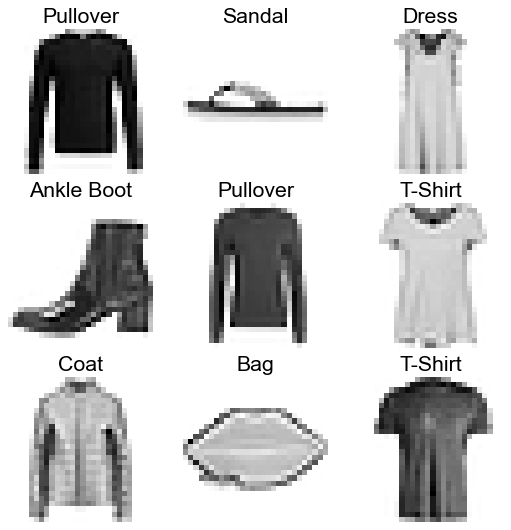

In [ ]:
import matplotlib.pyplot as plt


def plot_grid(data):
    """
    Function to randomly pull 9 images (and their labels) from a PyTorch dataset and display them
    """
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        # We pull an image at random and display it
        sample_idx = torch.randint(len(data), size=(1,)).item()
        img, label = data[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0), cmap="binary")
    return figure


plot_grid(training_data)
plt.show()

## Definition of a CNN

### Convolution layer

Let's start by familiarizing ourselves with the Pytorch 2D convolution layer, or [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).

**Tasks:**

1. The first parameter of `Conv2D` is the number of channels in the input image. (There is only one channel for these black and white images.)
2. Create a simple model by directly assigning a convolution layer to `model`, for example `model = nn.conv2d(*args)`. The convolution layer should have the adequate number of input channels for the FashionMNIST data and 8 output channels. Use a 5-pixel kernel for the convolution.
4. Display the parameters of this model. What is the format (`shape`) of weights?


In [4]:
from torch import nn

model = nn.Conv2d(1, 8, 5)

In [5]:
named_parameters = list(model.named_parameters())
print(named_parameters)

[('weight', Parameter containing:
tensor([[[[ 0.0800, -0.1799,  0.1703,  0.0339,  0.0554],
          [ 0.1457, -0.0275, -0.0277,  0.0035,  0.1321],
          [ 0.0712,  0.1540, -0.0917, -0.0476,  0.0065],
          [-0.1241, -0.0134,  0.1495,  0.1670, -0.1185],
          [-0.1769, -0.1931, -0.0075,  0.1401, -0.1695]]],


        [[[-0.0206,  0.0617,  0.0442, -0.0014,  0.1138],
          [-0.1092,  0.0176, -0.0281,  0.1778,  0.1826],
          [ 0.1960,  0.0975,  0.1572, -0.1681, -0.0474],
          [-0.0475,  0.1754,  0.1790, -0.1781, -0.1130],
          [ 0.0893, -0.1466, -0.0501, -0.1676,  0.1343]]],


        [[[ 0.0216, -0.0785, -0.1971, -0.1649, -0.0032],
          [ 0.0031,  0.1500, -0.1767,  0.1741,  0.1568],
          [-0.1509, -0.0530, -0.1620, -0.1160,  0.1937],
          [-0.0961, -0.1331,  0.1240, -0.0296,  0.0672],
          [ 0.1318, -0.0978, -0.0728, -0.1708,  0.1805]]],


        [[[-0.1671,  0.1997, -0.0913,  0.1932, -0.0567],
          [ 0.0721, -0.1631, -0.1789,  0.0

In [6]:
print("Weight format", named_parameters[0][1].shape)

Weight format torch.Size([8, 1, 5, 5])


**Now, pass one of the training images in the model. What are the output dimensions? Are the output dimensions what you would expect?**

In [7]:
img = training_data[514][0]
print("Image format", img.shape)
out = model(img)
print("Output", out.shape)

Image format torch.Size([1, 28, 28])
Output torch.Size([8, 24, 24])


### Calculation of output dimensions

For a single layer of convolution, it is easy to check the output dimensions (height and width). For a padding of type `same`, it is quite easy: the output dimensions are equal to those of input. 
However, for a `valid` padding (`padding = 0`), this will not be the case. In the general case, for an image of height and width $H_{in}$, the height and width of the output layer is given by:
$$
H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding} - \text{dilation}
                        \times (\text{kernel\_size} - 1) - 1}{\text{stride}} + 1\right\rfloor
$$

For us, in most cases:
- `padding = 0` because we use a default `valid` convolution
- `stride = 1` because we slide the pixel convolution core by pixel
- `dilation = 1` we do not dilate the kernel

We can intuitively see that:

- A larger `padding` increases the output dimension
- A bigger `stride` decreases the dimensions
- A larger kernel also results in a smaller output dimension: the more of the image the kernel pixels cover, the less space we have a play to slide the convolution. It's a bit of the same idea with dilation.

**To make life easier, we can also write a function that makes this calculation. Implement a function that calculates this equation and check its result with the above convolution.**

In [8]:
def get_output_width(input_width, kernel_size, stride=1, padding=0, dilation=1):
    """
    - input_width: size of input
    - kernel_size: size of kernel
    - stride: pas effectué par le noyau convolution
    - padding: number of pixel of padding (e.g, 0 pour valid)
    - dilation: Spacing between the kernel pixels
    # Ref: https://pytorch.org/docs/stable/generated/torch.nn.conv2d.html#Torch.nn.conv2d
    **Attention: stride=kernel_size for max pooling by default**
    """

    return int(
        (input_width + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1
    )

### Different padding

**Task: Use an alternative model with a padding `same`. Is the output layer formatted in the expected way?**

In [9]:
model = nn.Conv2d(1, 8, 5, padding="same")

In [10]:
img = training_data[514][0]
print("Image format", img.shape)
out = model(img)
print("Output", out.shape)

Image format torch.Size([1, 28, 28])
Output torch.Size([8, 28, 28])


### Pooling Layers

Pytorch also implements pooling layers: [nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html).

**Task: Implement a max pooling layer with `kernel_size = 5` and use it on an image. What are the output dimensions? How do they differ from a convolution? Is it consistent with the equation seen above? Display the initial image and the result of the pooling in two axes next to each other.**

<Details>
    <Summary> Explanation concerning the output size </ Summary>
    The default for `MaxPool2d` is that the `Stride` is equal to the `kernel_size`.
</ details>

In [11]:
pool = nn.MaxPool2d(5)

In [12]:
print("Image format", img.shape)
out = pool(img)
print("Output", out.shape)

Image format torch.Size([1, 28, 28])
Output torch.Size([1, 5, 5])


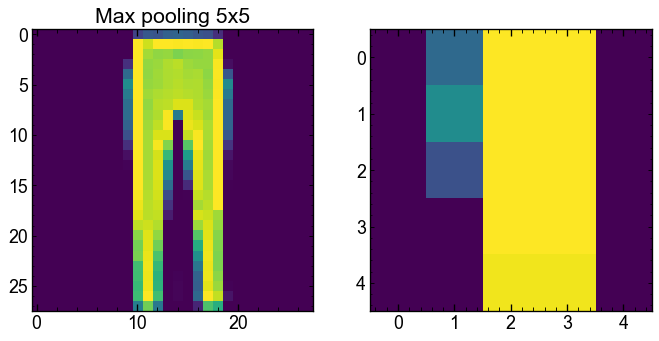

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img.squeeze())
axs[0].set_title("Image")
axs[1].imshow(out.squeeze())
axs[0].set_title("Max pooling 5x5")
plt.show()

### Definition of a complete CNN

To define a CNN, simply combine one or more convolution and pooling layers in a neural network.

**Task: Define a CNN with the characteristics below.**

1) A first layer of convolution with 6 output channels and a kernel size of 5
2) A second layer of convolution with 16 output channels and a kernel size of 5
3) Apply `nn.flatten` to the images.
4) Finally, add three fully-connected layers with 120, 84 and 10 neurons 

Additional design choices
- Note that you should apply the activation function after each convolution layers. Use the ReLU function as the activation function for all layers except the last
- Use a 2x2 "max" pooling after the activation of each convolution layers.

**The implementation is as follows:**

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Pooling 2x2, assigned to Pool because we reuse it several times
        self.pool = nn.MaxPool2d(2)
        self.activation = nn.ReLU()

        # Define convolutions sequence (Steps 1-2)
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            self.activation,
            self.pool,
            nn.Conv2d(6, 16, 5),
            self.activation,
            self.pool,
        )

        # Define operations to convert 2D images to 1D (Step 3)
        self.flatten = nn.Flatten()

        # Define a function to claculate the input dimension of the first fully connected layer
        self.linear_entry_dim = get_output_width(
            get_output_width(get_output_width(get_output_width(28, 5), 2, stride=2), 5),
            2,
            stride=2,
        )

        # Define sequence of fully connected layers (Step 4)
        self.linear_stack = nn.Sequential(
            nn.Linear(16 * self.linear_entry_dim**2, 120),
            self.activation,
            nn.Linear(120, 84),
            self.activation,
            nn.Linear(84, 10),
        )

    def forward(self, x):
        # The stack of 2 convolution layers (Steps 1-2)
        x = self.conv_stack(x)
        # Flatten the image (Step 3)
        x = self.flatten(x)
        # The fully connected sequence (Step 4)
        logits = self.linear_stack(x)
        return logits

**Create an instance of your model on your `device` (GPU or CPU).**

In [15]:
model = ConvNet().to(device)

**What is the input dimension of the first fully connected layer?**

In [16]:
model.linear_entry_dim

4

### Rapid model test

**Make sure your model works on a single image taken from `Training_Data`.**
Note: To feed an individual image into the model, you have add an extra dimension of length `1`. This way, it is a "batch of images" with one image in it. The img.unsqueeze(0) command does that.

**Also test it on a batch of images taken with `Train_Dataloader`.**

In [17]:
model(img.unsqueeze(0))

tensor([[ 0.0998, -0.0057,  0.0301,  0.0504, -0.0208,  0.0546, -0.0339,  0.0469,
          0.1115, -0.0349]], grad_fn=<AddmmBackward0>)

In [18]:
model(next(iter(train_dataloader))[0]).shape

torch.Size([64, 10])

## Training

**Train the network with a objective function. Use the loss function ``CrossEntropyLoss()`` as our objective function. Use torch.optim.SGD as the optimizer**

The necessary steps are:
1) Definition of the objective function and the optimizer
2) Definition of a training loop and a test loop
3) Iteration on epochs (start with 10)

In [19]:
learning_rate = 1e-3
batch_size = 64

In [20]:
loss_fn = nn.CrossEntropyLoss()

In [21]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    """Definition of the training loop"""

    # Size of the training set
    size = len(dataloader.dataset)

    # Iteration on batches (Dataloader gives us the data by Batch)
    # X is the image and the class
    train_loss = 0.0
    for batch, (X, y) in enumerate(dataloader):
        # Objective function
        pred = model(X)  # prediction
        loss = loss_fn(pred, y)

        # Retropropagation
        optimizer.zero_grad()  # We reset the gradient first
        loss.backward()  # Retropropagation
        optimizer.step()  # We take a step in the parameter space

        loss, current = loss.item(), batch * len(X)
        train_loss += loss * X.size(0)
        # Progress
        if batch % 100 == 0:
            print(f"Loss:{loss}, [{current}/{size}]")

    return train_loss / size

In [ ]:
def test_loop(dataloader, model, loss_fn):
    """Definition of the testing loop"""

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = correct = 0

    # We save the gradients as they are not used
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()  # Compute loss
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy:{(100*correct)}%, Avg loss:{test_loss} \n")

    return test_loss

**Now execute the 10 epochs of training and testing:**

In [24]:
epochs = 10
train_losses = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    test_loss = test_loop(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
Loss:2.3017871379852295, [0/60000]
Loss:2.30625057220459, [6400/60000]
Loss:2.2971277236938477, [12800/60000]
Loss:2.3157424926757812, [19200/60000]
Loss:2.295614004135132, [25600/60000]
Loss:2.2975716590881348, [32000/60000]
Loss:2.289705276489258, [38400/60000]
Loss:2.295926094055176, [44800/60000]
Loss:2.2908248901367188, [51200/60000]
Loss:2.287660837173462, [57600/60000]
Test Error: 
 Accuracy:18.54%, Avg loss:2.2949774462705963 

Epoch 2
-------------------------------
Loss:2.2951083183288574, [0/60000]
Loss:2.303185224533081, [6400/60000]
Loss:2.2929487228393555, [12800/60000]
Loss:2.290064811706543, [19200/60000]
Loss:2.2937610149383545, [25600/60000]
Loss:2.2975902557373047, [32000/60000]
Loss:2.287031888961792, [38400/60000]
Loss:2.2834343910217285, [44800/60000]
Loss:2.279813051223755, [51200/60000]
Loss:2.273085117340088, [57600/60000]
Test Error: 
 Accuracy:19.15%, Avg loss:2.2815550937774076 

Epoch 3
-------------------------------

**Display the evolution of loss function for training and test data.**


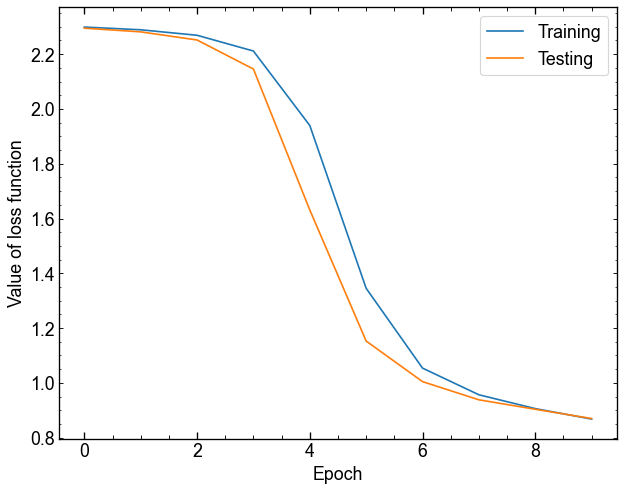

In [25]:
plt.plot(train_losses, label="Training")
plt.plot(test_losses, label="Testing")
plt.xlabel("Epoch")
plt.ylabel("Value of loss function")
plt.legend()
plt.show()

Note that the performance after 10 epochs is not great! This is partly explained by the fact that our network is very simple and partly by the fact that we cut training relatively early.

**Note:**With the SGD optimizer and the number of epochs that we use, it may be that training did not work well. If you have less than 50% precision you can add some epochs and start training (or continue from where it stopped).

## Model inspection

For a CNN, we can try to interpret the weights in the different convolutions.

**Access the first layer of convolution. Then access its weights and display the weight for the different channels.**

<Details>
    <Summary> index </summary>
    You will first have to access `Conv_Stack` and` Conv_Stack` is like a list, so you can index.
</ details>

In [26]:
conv1 = model.conv_stack[0]

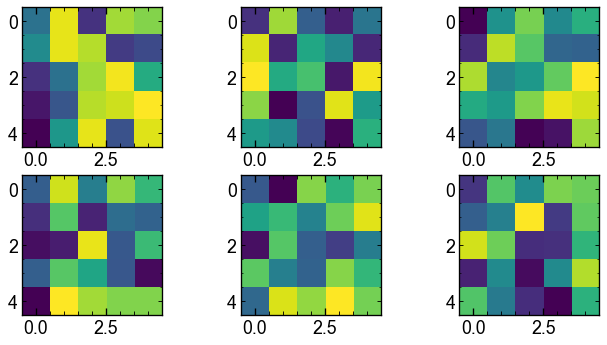

In [27]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5))
axs = axs.ravel()
for i in range(len(axs)):
    axs[i].imshow(conv1.weight[i].squeeze().detach())

Quite difficult to interpret anything here!

**Now display the outings of the first layer for an image drawn at random from the training data**.

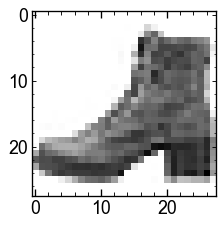

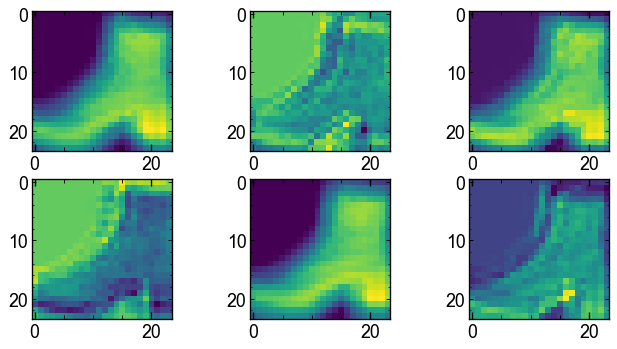

In [ ]:
import random

img = training_data[random.randint(0, len(training_data))][0]
out1 = conv1(img.unsqueeze(0)).squeeze()

plt.figure(figsize=(3, 3))
plt.imshow(img.squeeze(), cmap="binary")
plt.show()

fig, axs = plt.subplots(2, 3, figsize=(10, 5))
axs = axs.ravel()
for i in range(len(axs)):
    axs[i].imshow(out1[i].detach())

## Voluntary exercises

- Modify the network above by adding channels, layers and/or by modifying the size of the kernel of convolutions and explore the effect on the result.
-Modify the network above so that it accepts RGB images with 3 channels and test the data on CIFAR-10 data (`Torchvision.datasets.cifar10 ')
- Use a "dropout" in the model (see [nn.dropout](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html) for more information)
- Use a "normal batch" ([nn.batchnorm1d](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) for more information)